In [1]:
#matplotlib.use('Agg')
%pylab inline
import matplotlib.colors as colors
import healpy as hp, pickle
#cmap = cm.jet
import prepare as pre
import cosmology as cosmo
import math
nside = 512
iadd    = 0
add_the = [0,np.pi/2,np.pi/4]
add_phi = [0,np.pi/2,np.pi/4]


Populating the interactive namespace from numpy and matplotlib


In [2]:
class dL_z():
    def __init__(self,om0,ol0,ww):
        self.nz = 10000
        self.zmin  = 0.
        self.zmax  = 10.
        self.zstep = (self.zmax-self.zmin)/self.nz
        self.zbin  = self.zstep*np.arange(self.nz)+self.zmin
        self.dC    = np.zeros(self.nz)
        for i in np.arange(self.nz):
            self.dC[i] = cosmo.d_comoving_w(self.zbin[i],ol0,om0,ww)
        self.coef_dz  = np.polyfit(self.dC,   self.zbin, 10)
        self.coef_zd  = np.polyfit(self.zbin, self.dC,   10)

class CMB():
    def __init__(self,flag_G):
        self.nside = nside
        self.map   = np.load('COM_CMB_IQU-smica_'+np.str(nside)+'_R3.00_hm1.npy')
        
class ISW():
    def __init__(self,om0,ol0):
        self.om0    = om0
        self.ol0    = ol0
        self.boxize = pre.boxize/1.
        self.boxhalf= pre.boxize/2.
        self.nx     = 512
        self.nsnap  = 8
        self.step   = self.boxize/self.nx
        self.edgex  = self.step*np.arange(self.nx+1)
        self.cM     = 300000. # km/s
        self.H0     = 100 #100h km/s /Mpc,h=0.1
        _zsnap  = np.loadtxt(pre.simu+'_snapz.dat')
        self.snap   = np.int32(_zsnap[:,0])
        self.zsnap  = _zsnap[:,1]
        self.zstart,self.zend = 0.2,0.6#0.01,0.6
        self.rstart = cosmo.d_comoving(self.zstart,self.ol0,self.om0)
        self.rend   = cosmo.d_comoving(self.zend,self.ol0,self.om0)
        self.nstart = np.int32(cosmo.d_comoving(self.zstart,self.ol0,self.om0)/self.step)
        self.nend   = np.int32(cosmo.d_comoving(self.zend  ,self.ol0,self.om0)/self.step)
        self.nside  = nside
        self.npix   = hp.nside2npix(self.nside)
        self.pix    = np.arange(self.npix)
    def dln_growth(self,z1,z2):
        _x1,_x2 = 1./(1+z1),1./(1+z2)
        _y1,_y2 = cosmo.GF(_x1,1.,self.om0,self.ol0),cosmo.GF(_x2,1.,self.om0,self.ol0)
        return np.log(_y1/_y2)/np.log(_x1/_x2)
    def as_cmb(self):
        return -3./2*self.om0*self.H0*self.H0
    def load_density(self,i):
        self.h0     = np.load('../figure/dfy'+pre.simu+'-'+np.str(i)+'-map.npy')
        self.h0     = (self.h0).reshape((self.nx,self.nx,self.nx))
        _hm         = np.mean(self.h0)
        self.h0     = (self.h0-_hm)*1./_hm
    def isw_3d(self,hz,zl):
        _hz_f       = pre.fft3d(hz)
        _k2         = pre.fft3d_freq(self.nx,self.nx,3*self.nx)
        _phi_f      = self.as_cmb()*_hz_f/_k2
        _phi_f[0,0] = 0+0j
        _Hz         = self.H0*cosmo.E_z(zl,self.om0,self.ol0,0,0)
        _beta       = self.dln_growth(zl+0.05,zl)
        _dphi_f     = -_phi_f*_Hz*(1-_beta)
        _dphi       = np.real(np.fft.ifftn(_dphi_f))
        return 2/self.cM**3*2.7*_dphi#*self.step
    def isw(self,flag_load,flag_T_load):
        self.dT     = np.zeros((self.nx,self.nx,self.nx*5))
        if(flag_T_load==0):
            for i in np.arange(self.nsnap-1)+1:
                _z1     = self.zsnap[i]
                _z2     = self.zsnap[i-1]
                _zm     = 0.5*(_z1+_z2)
                if(flag_load==0):
                    self.load_density(self.snap[i])
                    self.rotate_joint()
                    _tmp  = self.isw_3d(self.h0,_zm)
                    np.save('../figure/dfy'+pre.simu+'-'+np.str(self.snap[i])+'-map3d-3box-T.npy',_tmp)
                if(flag_load==1):
                    _tmp  = np.load('../figure/dfy'+pre.simu+'-'+np.str(self.snap[i])+'-map3d-3box-T.npy')
                if(i==self.nsnap-1): _r1 = 0
                else: _r1 = cosmo.d_comoving(_z1,self.ol0,self.om0)
                if(i==1): _r2 = self.boxize*3.
                else: _r2 = cosmo.d_comoving(_z2,self.ol0,self.om0)

                #rotate and stack boxes
                print('i,snap[i],_z1,_z2,_zm=',i,self.snap[i],_z1,_z2,_zm,_r1,_r2)
                self.replace(_tmp,_r1,_r2)
            np.save('../figure/dfy'+pre.simu+'-map3d-curve3box-T.npy',self.dT)
        if(flag_T_load==1):
            self.dT = np.load('../figure/dfy'+pre.simu+'-map3d-curve3box-T.npy')
    def rotate_joint(self):
        _tmp = self.h0.copy()
        self.h0 = np.zeros((self.nx,self.nx,3*self.nx))
        self.h0[:,:,:self.nx]               = pre.arr_3d_3d_xyz(_tmp,0,self.nx,2)
        self.h0[:,:,self.nx:2*self.nx]   = pre.arr_3d_3d_xyz(_tmp,0,self.nx,1)
        self.h0[:,:,2*self.nx:3*self.nx] = pre.arr_3d_3d_xyz(_tmp,0,self.nx,0)
    def replace(self,dT,r1,r2):
        index = ((self.pos[0]**2+self.pos[1]**2+self.pos[2]**2)>=r1**2)*((self.pos[0]**2+self.pos[1]**2+self.pos[2]**2)<r2**2)
        self.dT[:,:,:self.pos.shape[3]][index] = dT[index].copy()
    def gen_edge_radec(self):
        self.dmax       = self.rend#self.boxize*3.
        self.ran        = np.zeros((3,2))
        r2 = np.sqrt(self.boxhalf**2.+self.dmax**2.)
        r3 = np.sqrt(r2**2.+self.boxhalf**2.)
        self.ran[0,1]   = np.arcsin(self.boxhalf/r3) #theta
        self.ran[1,1]   = np.arcsin(self.boxhalf/r2) #phi
        self.ran[0,0],self.ran[1,0] = -self.ran[0,1],-self.ran[1,1]
        self.ran[2,0],self.ran[2,1] = self.zstart,self.zend
    def gen_xyz(self):
        _tmp1 = (np.arange(self.nx)+0.5)*self.step - self.boxhalf
        _tmp2 = (np.arange(self.nx*3)+0.5)*self.step
        self.pos = np.array(np.meshgrid(_tmp1,_tmp1,_tmp2))
    def gen_radec_dT(self):
        dlz = dL_z(self.om0,self.ol0,-1.)
        self.gen_xyz()
        self.gen_edge_radec()
    def gen_ray(self,rstart,rend):
        theta,phi   = hp.pix2ang(self.nside,self.pix,nest=True) #90-dec,ra
        ra_h,dec_h  = phi-pre.dra,np.pi/2-theta #(ra here is not the standard ra)
        index       = np.where( (ra_h>self.ran[1,0]) & (ra_h<self.ran[1,1]) & (dec_h>self.ran[0,0]) & (dec_h<self.ran[0,1]) )
        self.nr_ray = 512
        self.sepr_r = (rend-rstart)/self.nr_ray#Mpc/h along redshift
        self.xr     = ra_h[index]
        self.yr     = dec_h[index]
        self.rr     = self.sepr_r*(np.arange(self.nr_ray)+0.5) + rstart
        self.theta,self.phi,self.index = theta,phi,index
    def gene_cmb(self,flag_simu):
        if(flag_simu==0): self.cmb = np.load('COM_CMB_IQU-smica_'+np.str(self.nside)+'_R3.00_hm1.npy')
        else:
            cl       = np.loadtxt('pycamb/TT_power.txt')
            _cmb     = hp.synfast(cl,self.nside)
            self.cmb = hp.reorder(_cmb,inp='RING',out='NESTED')
    def center_theta_phi(self,tmap,the,phi,a_the,a_phi):
        r           = hp.rotator.Rotator(coord=['C','G'])
        _theta_cmb,_phi_cmb = r(the,phi)
        _index_cmb = hp.ang2pix(self.nside,_theta_cmb+a_the,_phi_cmb+a_phi,nest=True)
        _rmap   = np.zeros(self.npix)
        _index_ori = hp.ang2pix(self.nside,the,phi,nest=True)
        _rmap[_index_ori] = tmap[_index_cmb]
        return _rmap
    def add_cmb(self,theta,phi,flag_simu):
        self.add_cmb = self.center_theta_phi(self.cmb,self.theta,self.phi,add_the[iadd],add_phi[iadd])
        if(flag_simu==1): fname = 'data/add_simu_cmb.npy'
        if(flag_simu==0): fname = 'data/add_real_cmb.npy'
        np.save(fname,self.add_cmb[self.index_ori])
    def trace_ray(self,ipix): #error here before
        #pos[:3]: theta2(ra),theta1(dec),r
        index_x1 = np.int32(np.floor(self.rr*np.sin(self.yr[ipix])/self.step)+self.nx/2)
        index_x2 = np.int32(np.floor(self.rr*np.cos(self.yr[ipix])*np.sin(self.xr[ipix])/self.step)+self.nx/2)
        index_x3 = np.int32(np.floor(self.rr*np.cos(self.yr[ipix])*np.cos(self.xr[ipix])/self.step))
        return np.sum(self.dT[index_x1,index_x2,index_x3])*self.sepr_r

In [3]:
mmd = lambda x:0.5*(x[1:]+x[:-1])
#(1) initialize
om0,ol0,ww = 0.268,0.732,-1.
flag_load    = 1
flag_T_load  = 1
dlz = dL_z(om0,ol0,ww)
#MP = 0.187042*10**10. #M_sun/h
#(2)
#produce ISW
Isw = ISW(om0,ol0)
Isw.gen_radec_dT()
Isw.isw(flag_load,flag_T_load)

In [4]:
flag_ray     = 0 #1-generate the ISW map, 0-load the ISW map
flag_add_cmb = 1 #add CMB to the ISW
if(flag_ray==0):
    Isw.gen_ray(Isw.rstart,Isw.rend)
    #Isw.add_realcmb()
    Isw.dT2 = np.zeros(Isw.npix)
    for i in np.arange(np.count_nonzero(Isw.index)):
        Isw.dT2[Isw.index[0][i]] = Isw.trace_ray(i)
    # np.save('../figure/'+pre.simu+'-'+np.str(Isw.zstart)+'-'+np.str(Isw.zend)+'-map3d-curve3box-T-healpix.npy',np.vstack((Isw.theta[Isw.index],Isw.phi[Isw.index],Isw.dT2[Isw.index])))

In [28]:
flag_simu_cmb= 0 #1-simu the CMB ourself, 0-use the real CMB map
Isw.gene_cmb(flag_simu_cmb)
Isw.angle_dT2 = np.vstack((Isw.theta[Isw.index],Isw.phi[Isw.index],Isw.dT2[Isw.index]))

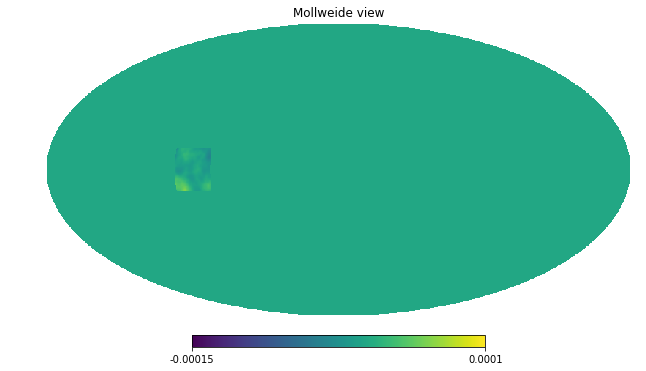

In [5]:
hp.mollview(Isw.dT2,nest=True,min=-1.5e-4,max=1e-4)

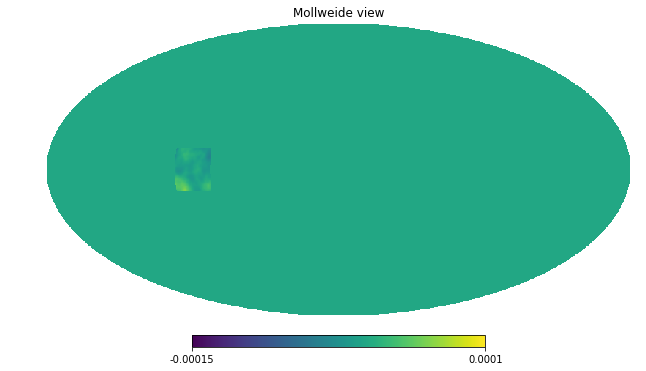

In [8]:
hp.mollview(Isw.dT2,nest=True,min=-1.5e-4,max=1e-4)

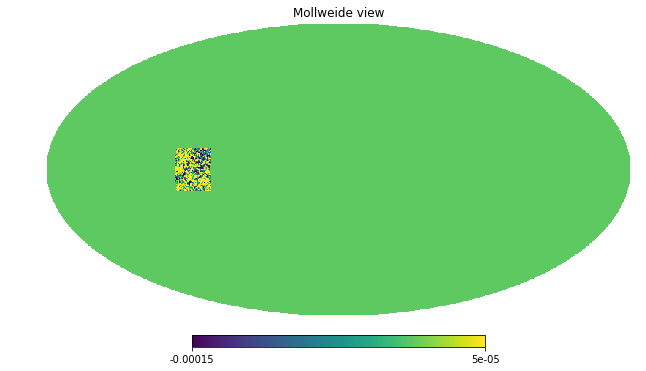

In [31]:
#Isw.add_cmb(Isw.dT2[0],Isw.dT2[1],flag_simu_cmb)
tmp = Isw.center_theta_phi(Isw.cmb,Isw.angle_dT2[0],Isw.angle_dT2[1],-np.pi*0.15,np.pi*0.35)
#tmp[Isw.index[0]] = Isw.cmb[Isw.index[0]].copy()
hp.mollview(tmp,nest=True,min=-1.5e-4,max=5e-5)

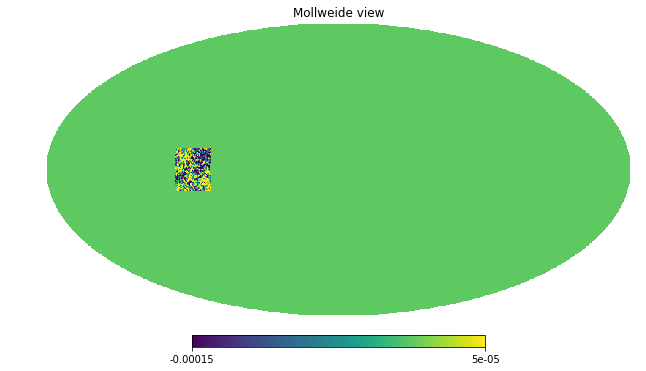

In [32]:
hp.mollview(Isw.dT2+tmp,nest=True,min=-1.5e-4,max=5e-5)

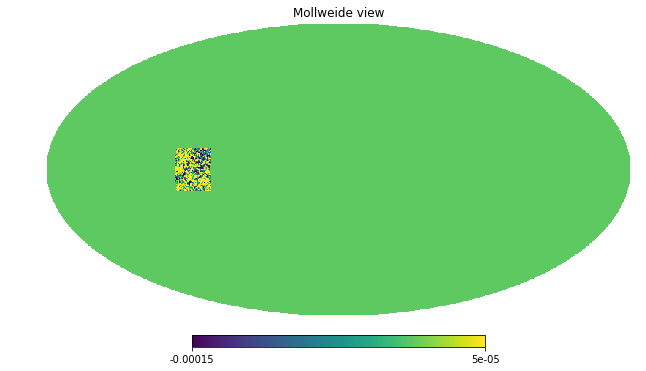

In [33]:
hp.mollview(tmp,nest=True,min=-1.5e-4,max=5e-5)

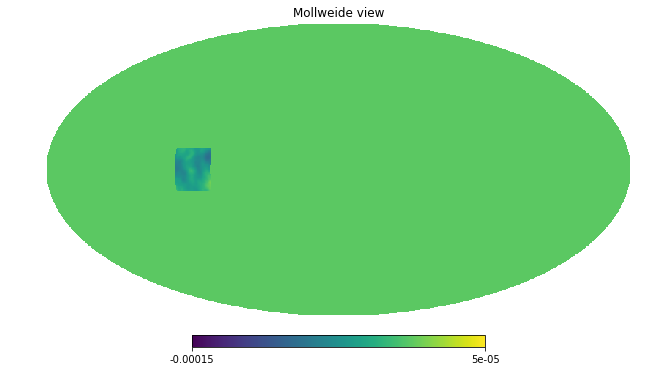

In [34]:
hp.mollview(Isw.dT2,nest=True,min=-1.5e-4,max=5e-5)

In [ ]:
'''
if(flag_ray==1):
    Isw.dT2 = np.load('../figure/'+pre.simu+'-'+np.str(Isw.zstart)+'-'+np.str(Isw.zend)+'-map3d-curve3box-T-healpix.npy')
    if(flag_add_cmb==1):
        Isw.gene_cmb(flag_simu_cmb)
        Isw.add_cmb(Isw.dT2[0],Isw.dT2[1],flag_simu_cmb)
'''

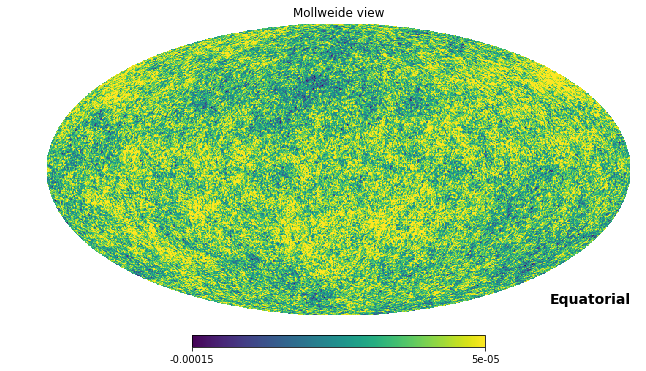

In [94]:
hp.mollview(Isw.cmb,nest=True,coord=['G','C'],min=-1.5e-4,max=5e-5)

In [7]:
import numpy as np
import sys
import treecorr as tc

class Simu:
    def __init__(self):
        self.dir_halo = '/home/fydong/work/8100/cal_halo/data/subhalo_pos/'
        self.dir_T    = '/home/fydong/work/8100/cal_halo/data/figure/'
        self.nr    = 40
        self.rmax   = 32*np.pi/180 #10[deg]
        self.rmin   = 10/60.*np.pi/180 #10[acrmin]
        self.rstep = np.log(self.rmax/self.rmin)/self.nr
        self.rbin  = np.exp(np.log(self.rmin)+self.rstep*np.arange(self.nr))
    def rr(self,x1,x2): #x[0]-lat-weidu,x[1]-lon-jingdu
        phi1 = (np.pi/2 - x1[0])
        phi2 = (np.pi/2 - x2[0])
        theta1 = x1[1]
        theta2 = x2[1]
        cos = (np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2)*np.cos(theta1-theta2))
        return np.arccos( cos )
    def index_rbin(self,x1,x2):
        _rtmp  = np.log(self.rr(x1,x2)/self.rmin)
        _index = np.int32(np.ceil(_rtmp/self.rstep))
        return _index

#in order to do jacknife, divid the regions into subregions. the number of subregions=nthread
class Thread:
    def __init__(self,nthread,ithread,nx,ny):
        nregion    = np.sqrt(nthread) #alog one direction
        self.stepx = np.int32(nx/nregion)
        self.stepy = np.int32(ny/nregion)
        regionx,regiony = np.int32(ithread/nregion),np.int32(ithread%nregion)
        self.beginx = self.stepx*regionx
        self.beginy = self.stepy*regiony

In [8]:
mlimit = '-22'
Radius = '7'
sname= '1'
zname  = '0.2-0.6'#'0.01-0.6'
Rname  = '-R'+Radius
simu = Simu()
k_halo   = np.load(simu.dir_halo+'BASSz'+zname+'Mag'+mlimit+'rr'+Radius+'radec-ldp-den-Mask-healpix.npy')
k_isw    = np.vstack((Isw.theta[Isw.index],Isw.phi[Isw.index],(Isw.dT2)[Isw.index]))
#k_isw    = np.vstack((Isw.theta[Isw.index],Isw.phi[Isw.index],(Isw.dT2+tmp)[Isw.index]))
#k_isw  = np.load(simu.dir_T+sname+'-'+zname+'-map3d-curve3box-T-healpix.npy')

In [9]:
#calculate cross correlation
au     = 180./np.pi
rmin,rmax  =  10,10*60
min_sep,max_sep = rmin,rmax
nbins = 15
#dataK = tc.Catalog(k=k_isw[2], ra=k_isw[1]*au, dec=(np.pi/2-k_isw[0])*au, ra_units='deg', dec_units='deg')
dataK = tc.Catalog(k=k_isw[2]-np.mean(k_isw[2]), ra=k_isw[1]*au, dec=(np.pi/2-k_isw[0])*au, ra_units='deg', dec_units='deg')
datag = tc.Catalog(k=k_halo[2],ra=k_halo[1]*au,dec=(np.pi/2-k_halo[0])*au,ra_units='deg', dec_units='deg')
Kg = tc.KKCorrelation( nbins=nbins, min_sep=min_sep, max_sep=max_sep, bin_slop=0.01, verbose=0, sep_units='arcmin' )
Kg.process(dataK,datag,metric='Arc',num_threads=10)
xim   = Kg.xi
rm    = Kg.meanr

In [12]:
xim

array([-2.67758832e-06, -2.61233609e-06, -2.56182304e-06, -2.42870375e-06,
       -2.32900840e-06, -2.13968306e-06, -1.91966464e-06, -1.65433177e-06,
       -1.34575429e-06, -1.02291236e-06, -7.23092526e-07, -3.54336127e-07,
        2.39133580e-08,  2.91313677e-07,  3.16073634e-07])

In [26]:
np.savetxt('dfy1true.dat',np.vstack((rm,xim*1e6)))

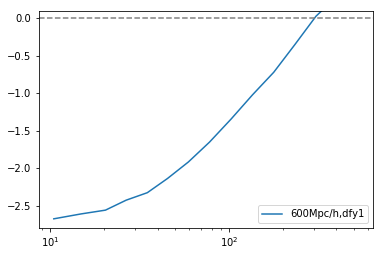

In [15]:
#xdfy1 = np.loadtxt('obs/ldpz0.2-0.6BASS-30-22R6nside512nsidecmb512nsidejack4.dat')
#plt.errorbar(xdfy1[0],xdfy1[1],yerr=xdfy1[2],label='obs')
plt.plot(rm,xim*1e6,label='600Mpc/h,dfy1')
plt.xscale('log')
plt.ylim(-2.8,0.1)
plt.axhline(0,ls='--',c='grey')
plt.legend()

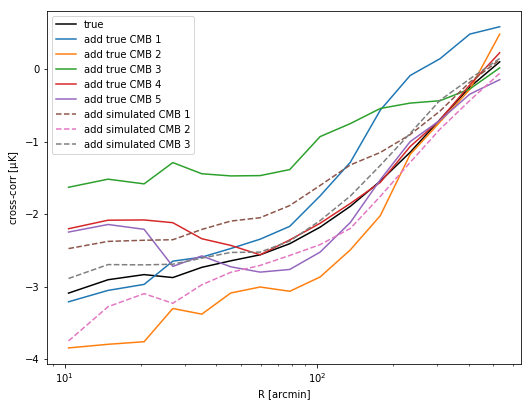

In [433]:
plt.figure(figsize=(8.5,6.5))
#plt.plot(rm,xim*1e6,label='this',c='g',ls='-.')
plt.xscale('log')

true = np.loadtxt('temp/true.dat')
plt.plot(true[0],true[1],label='true',c='black')
real = np.loadtxt('temp/realcmb1.dat')
plt.plot(real[0],real[1],label='add true CMB 1')
real = np.loadtxt('temp/realcmb2.dat')
plt.plot(real[0],real[1],label='add true CMB 2')
real = np.loadtxt('temp/realcmb3.dat')
plt.plot(real[0],real[1],label='add true CMB 3')
real = np.loadtxt('temp/realcmb4.dat')
plt.plot(real[0],real[1],label='add true CMB 4')
real = np.loadtxt('temp/realcmb5.dat')
plt.plot(real[0],real[1],label='add true CMB 5')


noise = np.loadtxt('temp/noise1.dat')
plt.plot(noise[0],noise[1],label='add simulated CMB 1',ls='--')
noise = np.loadtxt('temp/noise2.dat')
plt.plot(noise[0],noise[1],label='add simulated CMB 2',ls='--')
noise = np.loadtxt('temp/noise3.dat')
plt.plot(noise[0],noise[1],label='add simulated CMB 3',ls='--')
plt.xlabel('R [arcmin]')
plt.ylabel(r'cross-corr $\rm{[\mu K]}$')
plt.legend()
#np.savetxt('noise3.dat',np.vstack((rm,xim*1e6)))
#np.savetxt('noise2.dat',np.vstack((rm,xim*1e6)))
#np.savetxt('true.dat',np.vstack((rm,xim*1e6)))
#np.savetxt('realcmb5.dat',np.vstack((rm,xim*1e6)))

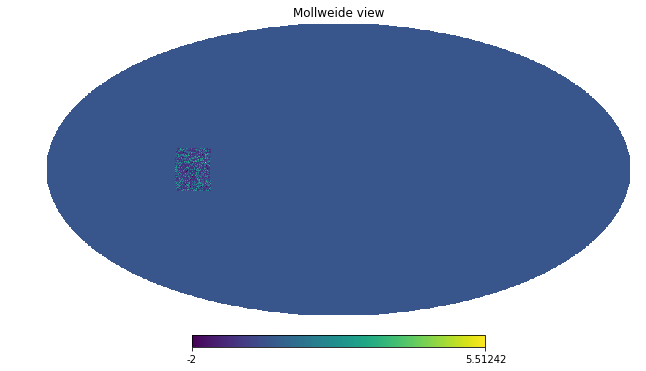

In [26]:
def heapy_map(theta,phi,mmap,nside,nest):
    pix = hp.ang2pix(nside,theta,phi,nest=nest)
    rmap = np.zeros(hp.nside2npix(nside)) #Blank healpix map
    np.add.at(rmap,pix,mmap)
    return rmap

#map_h = heapy_map(k_isw[1],k_isw[0],k_isw[2],512,True)
map_h = heapy_map(k_halo[1],k_halo[0],k_halo[2],512,True)
hp.mollview(map_h,nest=True)

In [12]:
#Mask halos
mlimit = '-22'
Radius = '5'
zname  = '0.01-0.6'
Rname  = '-R'+Radius
simu = Simu()
k_halo   = np.load(simu.dir_halo+'BASSz'+zname+'Mag'+mlimit+'rr'+Radius+'radec-ldp-den-Mask-healpix.npy')
k_isw    = np.vstack((Isw.theta[Isw.index],Isw.phi[Isw.index],(Isw.dT2)[Isw.index]))
#calculate cross correlation
au     = 180./np.pi
rmin,rmax  =  10,10*60
min_sep,max_sep = rmin,rmax
nbins = 15
dataK = tc.Catalog(k=k_isw[2], ra=k_isw[1]*au, dec=(np.pi/2-k_isw[0])*au, ra_units='deg', dec_units='deg')
datag = tc.Catalog(k=k_halo[2],ra=k_halo[1]*au,dec=(np.pi/2-k_halo[0])*au,ra_units='deg', dec_units='deg')
Kg = tc.KKCorrelation( nbins=nbins, min_sep=min_sep, max_sep=max_sep, bin_slop=0.01, verbose=0, sep_units='arcmin' )
Kg.process(dataK,datag,metric='Arc',num_threads=10)
xim   = Kg.xi
rm    = Kg.meanr

In [13]:
xim

array([-1.53085697e-06, -1.51411470e-06, -1.44756783e-06, -1.45411235e-06,
       -1.40349534e-06, -1.32163094e-06, -1.23383720e-06, -1.12165365e-06,
       -9.30040653e-07, -6.64266644e-07, -3.59684616e-07, -1.49196959e-07,
       -9.22304025e-08, -1.64955368e-07, -6.48051654e-08])

In [409]:
print(np.count_nonzero(Isw.index),k_halo.shape,k_isw.shape,np.count_nonzero(k_isw==0),np.count_nonzero(k_halo==0))

(123304, (3, 120479), (3, 123304), 0, 0)


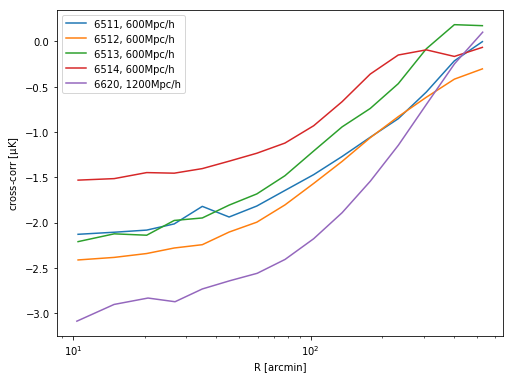

In [16]:
#np.savetxt('temp/corre-Mask4.dat',np.vstack((rm,xim*1e6)))
np.savetxt(pre.simu+'true.dat',np.vstack((rm,xim*1e6)))

plt.figure(figsize=(8,6))
#plt.plot(rm,xim*1e6,label='this',ls='--',c='b')
x6511 = np.loadtxt('6511true.dat')
plt.plot(x6511[0],x6511[1],label='6511, 600Mpc/h')
x6512 = np.loadtxt('6512true.dat')
plt.plot(x6512[0],x6512[1],label='6512, 600Mpc/h')
x6511 = np.loadtxt('6513true.dat')
plt.plot(x6511[0],x6511[1],label='6513, 600Mpc/h')
x6514 = np.loadtxt('6514true.dat')
plt.plot(x6514[0],x6514[1],label='6514, 600Mpc/h')
x6620 = np.loadtxt('/home/dfy/work/cal_halo_6620/data/produce-cmb//temp/true.dat')
plt.plot(x6620[0],x6620[1],label='6620, 1200Mpc/h')
'''
corre = np.loadtxt('temp/corre-Mask1.dat')
plt.plot(corre[0],corre[1],label='Mask1')

corre = np.loadtxt('temp/corre-Mask4.dat')
plt.plot(corre[0],corre[1],label='Mask2')

corre = np.loadtxt('corre-Mask3.dat')
plt.plot(corre[0],corre[1],label='Mask3')
'''
plt.xscale('log')
#true = np.loadtxt('temp/true.dat')
#plt.plot(true[0],true[1],label='true',c='black',ls=':')

plt.xlabel('R [arcmin]')
plt.ylabel(r'cross-corr $\rm{[\mu K]}$')
plt.legend()

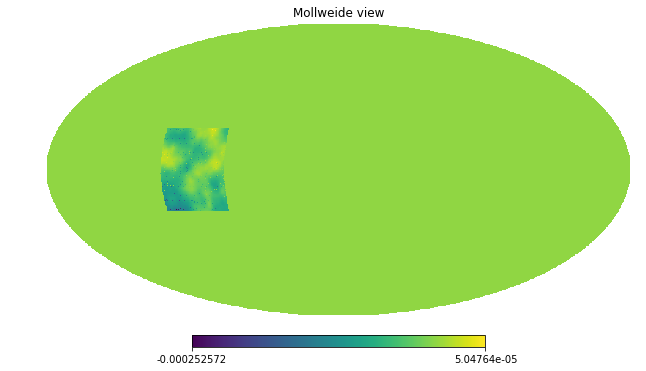

In [122]:
map_i = heapy_map(k_isw[1],k_isw[0],k_isw[2],512,True)
hp.mollview(map_i,nest=True)

In [147]:
Isw.theta[Isw.index].shape

(123304,)

In [435]:
(28991029248)**(1./3)

3071.9999999999986

In [30]:
pwd

u'/data/s3/dfy/data/cal_halo_data/produce-cmb'